## **IMPORTANT : Use Python 3.12.2,  To properly configure the Conda environment, download the attached env.yml file and run the following cell:**

In [3]:
!conda env create -f env.yml


CondaValueError: prefix already exists: /opt/anaconda3



## Dataset Loading and Preparation.



we import the necessary libraries (`pandas` and `os`).
load the Excel file FullDayWithAlarms.xlsx specifying `header=1` because the actual column names start from the second row of the file.
rename the columns in the dataframe to have clearer and more readable names.
convert the `Timestamp` column to datetime format, handling any errors (`errors='coerce'`) and specifying that the day/month/year format
 (`dayfirst=True`).
sort the dataframe by `Timestamp` to have the data in chronological order.
Display:
  - The first rows of the sorted dataset to get a preview of the data.
  - The descriptive statistics of the main columns of interest (`Code_ID`, `Number of Transactions`, `Time Min`, `Time Max`, `Retries`, `Wrong Transactions`).



In [4]:
import pandas as pd
import os

file_path = '/Users/fabioantonicoli/Desktop/ML_REPLY/FullDayWithAlarms.xlsx'

# Load Excel file
df = pd.read_excel(file_path, header=1)


df.columns = [
    "Code_ID", "Timestamp", "Acquisition Interval", "Number of Transactions",
    "Time Min", "Time Max", "Time Avg", "Retries", "Wrong Transactions"
]

# Convert Timestamp 
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True, errors='coerce')
df = df.sort_values(by='Timestamp')

# Output preview
print("First rows of the ordered dataset:")
print(df.head())

print("\nColumn summary statistics:")
print(df[[
    "Code_ID", "Number of Transactions", "Time Min", "Time Max", "Retries", "Wrong Transactions"
]].describe())



First rows of the ordered dataset:
   Code_ID           Timestamp  Acquisition Interval  Number of Transactions  \
0        8 2024-05-31 07:01:11                    60                     366   
1        8 2024-05-31 07:02:11                    60                     948   
2        8 2024-05-31 07:03:11                    60                    1273   
3        8 2024-05-31 07:04:11                    60                    1538   
4        8 2024-05-31 07:05:11                    60                     703   

   Time Min  Time Max   Time Avg  Retries  Wrong Transactions  
0         6      1019  25.907562        0                  90  
1         7        90  18.181719        0                  90  
2         7       408  18.813356        0                  90  
3         6        70  16.607435        0                  90  
4         5        85  16.645409        0                  90  

Column summary statistics:
       Code_ID  Number of Transactions     Time Min      Time Max  \
cou

## Installation and Import Check for TimeGAN

Installed the `ydata-synthetic` package.
Tried importing `TimeGAN` from two possible paths:
  - First: `ydata_synthetic.synthesizers`
  - Second (fallback): `ydata_synthetic.synthesizers.timeseries`
Printed success or failure messages to confirm the import.

Finally, imported basic libraries (`numpy` and `pandas`) for later use.

In [5]:
!pip install ydata-synthetic  

try:
    from ydata_synthetic.synthesizers import TimeGAN
    print("Importazione da ydata_synthetic.synthesizers riuscita!")
except ImportError:
    print("Importazione da ydata_synthetic.synthesizers fallita.")
    try:
       
        from ydata_synthetic.synthesizers.timeseries import TimeGAN
        print("Importazione da ydata_synthetic.synthesizers.timeseries riuscita!")
    except ImportError as e:
        print("Importazione da ydata_synthetic.synthesizers.timeseries fallita di nuovo.")
        print(f"Errore originale: {e}")

import numpy as np
import pandas as pd




Importazione da ydata_synthetic.synthesizers riuscita!


/var/folders/l7/xnyh1lh904xby1kp5mjh5fn40000gn/T/ipykernel_10269/2769622683.py:4: DeprecationWarning: `import ydata_synthetic.synthesizers` is deprecated. Please use `import ydata.sdk.synthesizers` instead.For more information check https://docs.synthetic.ydata.ai/latest and https://docs.fabric.ydata.ai/latest/sdk
  from ydata_synthetic.synthesizers import TimeGAN


## Exploratory Data Analysis (EDA)

We Set graphic style with Seaborn for cleaner plots.
Calculated descriptive statistics (`describe()`).
Plotted time series of `Number of Transactions` to visualize trends over time.
Built a correlation matrix heatmap to study relationships between numerical features.
Analyzed seasonality by creating a heatmap of average transactions by hour of the day.

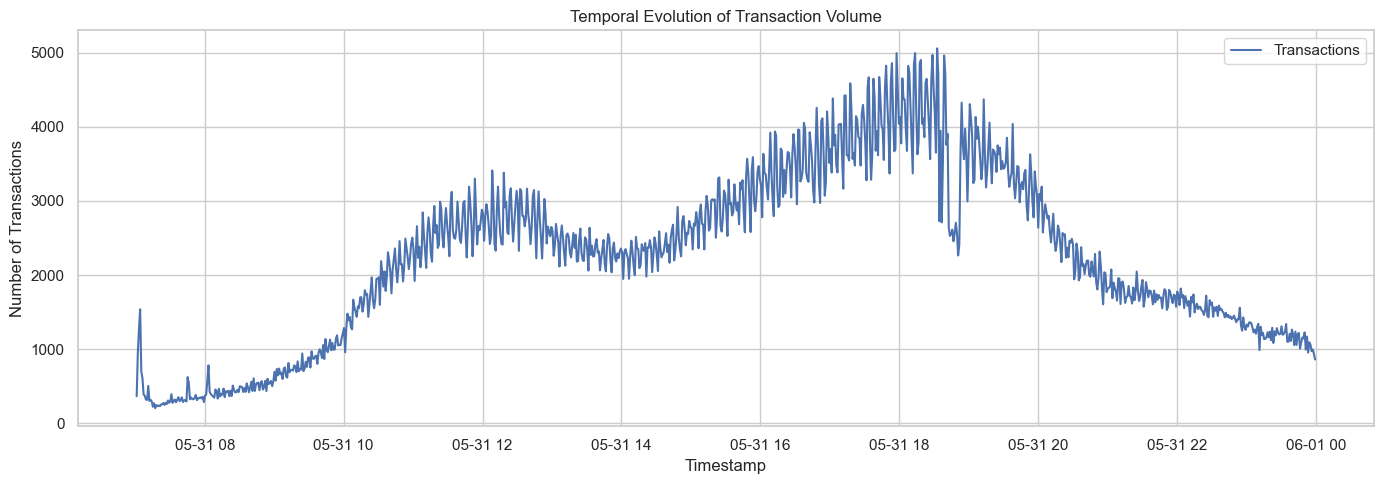

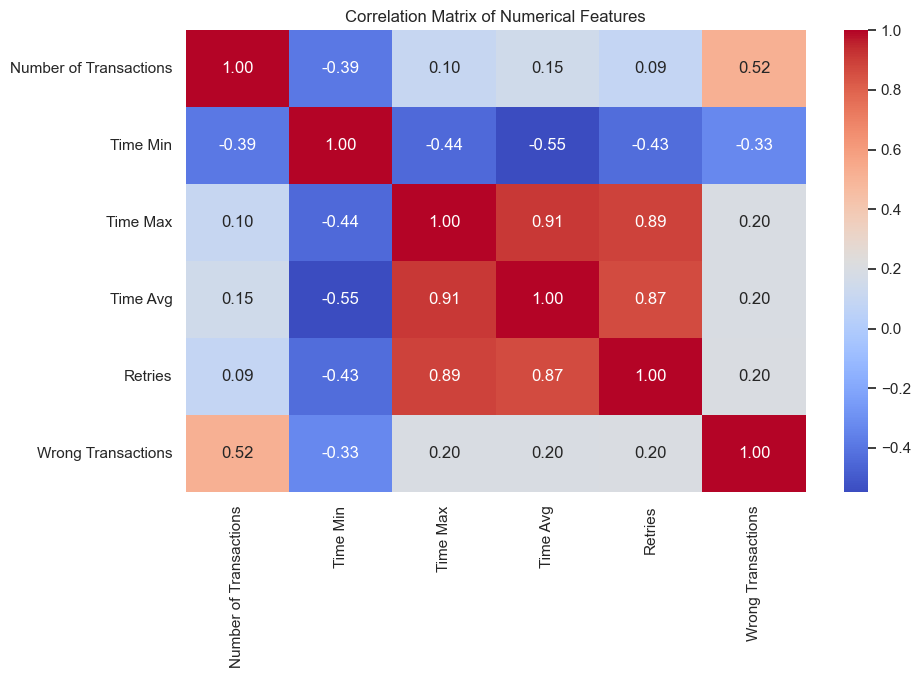

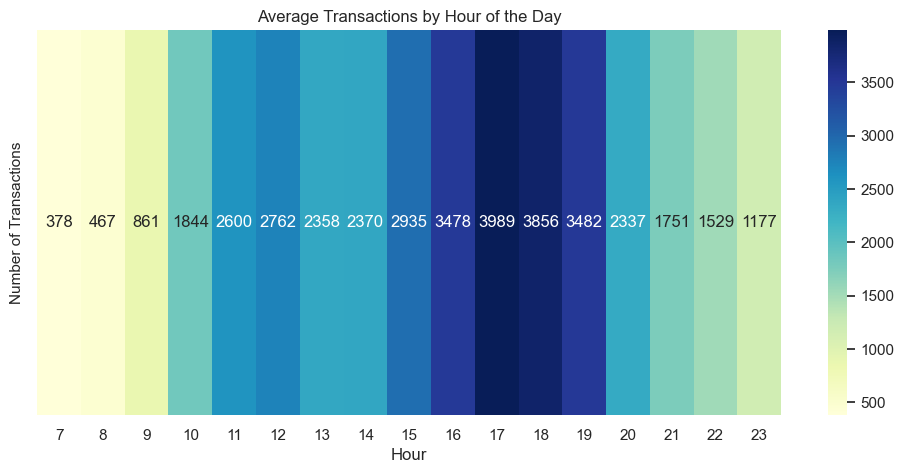

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

#  graphic style
sns.set(style="whitegrid")

# DESCRIPTIVE STATISTICS
desc_stats = df.describe()

# TIME SERIES PLOT
plt.figure(figsize=(14, 5))
plt.plot(df['Timestamp'], df['Number of Transactions'], label='Transactions')
plt.title("Temporal Evolution of Transaction Volume")
plt.xlabel("Timestamp")
plt.ylabel("Number of Transactions")
plt.legend()
plt.tight_layout()
plt.show()

# CORRELATION BETWEEN NUMERICAL VARIABLES
correlation_matrix = df[[
    "Number of Transactions", "Time Min", "Time Max", "Time Avg", "Retries", "Wrong Transactions"
]].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


# HEATMAP BY HOUR OF THE DAY 
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Time Slot'] = df['Hour'].astype(str).str.zfill(2) + ":" + df['Minute'].astype(str).str.zfill(2)

heatmap_data = df.groupby(['Hour'])['Number of Transactions'].mean().reset_index()
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data.set_index('Hour').T, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title("Average Transactions by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("")
plt.show()


## Transformations and Smoothing

Applied a 10-period rolling mean to smooth the `Number of Transactions`.
Applied a log transformation (log(x + 1)) to stabilize variance (only for positive values).
Plotted original vs rolling mean to visualize smoothing effect.
Prepared for updated descriptive statistics analysis.


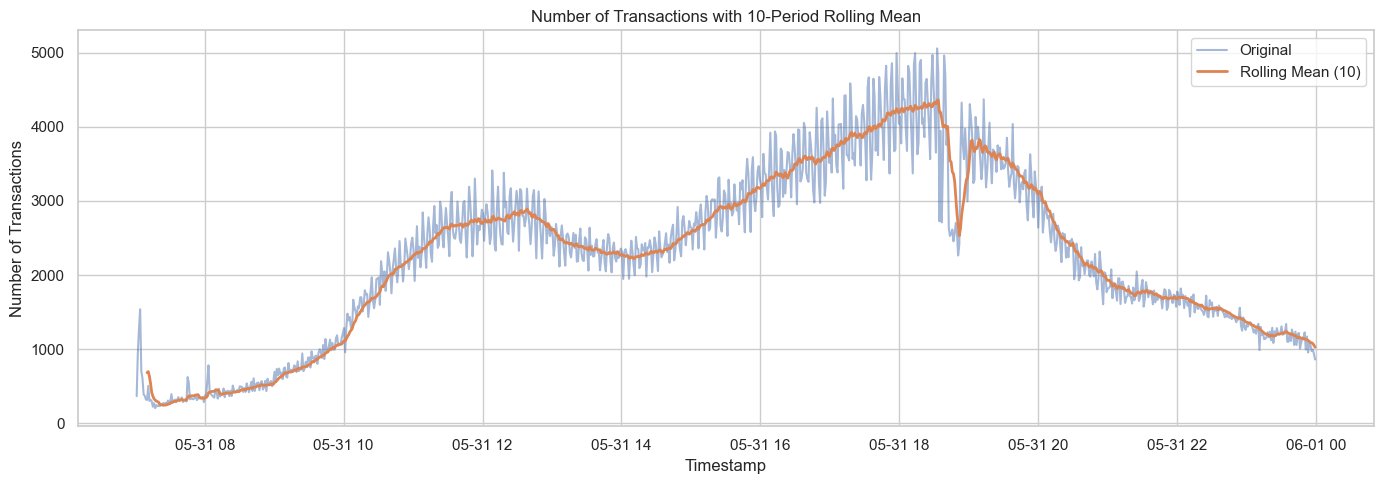

,Code_ID,Timestamp,Acquisition Interval,Number of Transactions,Time Min,Time Max,Time Avg,Retries,Wrong Transactions
count,1018.0,1018,1018.0,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,8.0,2024-05-31 15:30:13.430255616,60.0,2245.859528,2.737721,1346.666994,49.715493,89.292731,155.943026
min,8.0,2024-05-31 07:01:11,60.0,204.000000,0.000000,28.000000,9.462604,0.000000,81.000000
25%,8.0,2024-05-31 11:15:37,60.0,1424.750000,3.000000,82.000000,11.039727,0.000000,122.250000
50%,8.0,2024-05-31 15:30:09,60.0,2323.000000,3.000000,124.000000,12.349440,0.000000,149.000000
75%,8.0,2024-05-31 19:44:54,60.0,3007.000000,3.000000,232.500000,13.582763,0.000000,186.000000
max,8.0,2024-05-31 23:59:23,60.0,5057.000000,7.000000,92682.000000,2019.271700,6496.000000,448.000000
std,0.0,NaN,0.0,1136.991871,0.934939,7207.947520,182.782991,599.256239,47.440950


In [7]:
# TRANSFORMATIONS: rolling mean and log
df['Transactions_RollingMean'] = df['Number of Transactions'].rolling(window=10).mean()
df['Transactions_Log'] = df['Number of Transactions'].apply(lambda x: np.log(x + 1))

# Visualization of rolling mean
plt.figure(figsize=(14, 5))
plt.plot(df['Timestamp'], df['Number of Transactions'], label='Original', alpha=0.5)
plt.plot(df['Timestamp'], df['Transactions_RollingMean'], label='Rolling Mean (10)', linewidth=2)
plt.title("Number of Transactions with 10-Period Rolling Mean")
plt.xlabel("Timestamp")
plt.ylabel("Number of Transactions")
plt.legend()
plt.tight_layout()
plt.show()

desc_stats


## Time Series Decomposition

For each main numerical feature, resampled the data to an hourly frequency (`resample('H')`).
Dropped NaN values after resampling.
Applied additive seasonal decomposition (`seasonal_decompose`) to separate:
  - Observed series
  - Trend component
  - Seasonal component
  - Residuals
- Plotted the decomposition for visual analysis of patterns and anomalies.

In [8]:
df = df.set_index('Timestamp')

### Installing statsmodels
To use time series decomposition and other statistical tools, we need the `statsmodels` library.  
If it's not already installed in your environment, you can easily add it by running:


In [9]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


/var/folders/l7/xnyh1lh904xby1kp5mjh5fn40000gn/T/ipykernel_10269/608481662.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df[c].resample('H').mean()


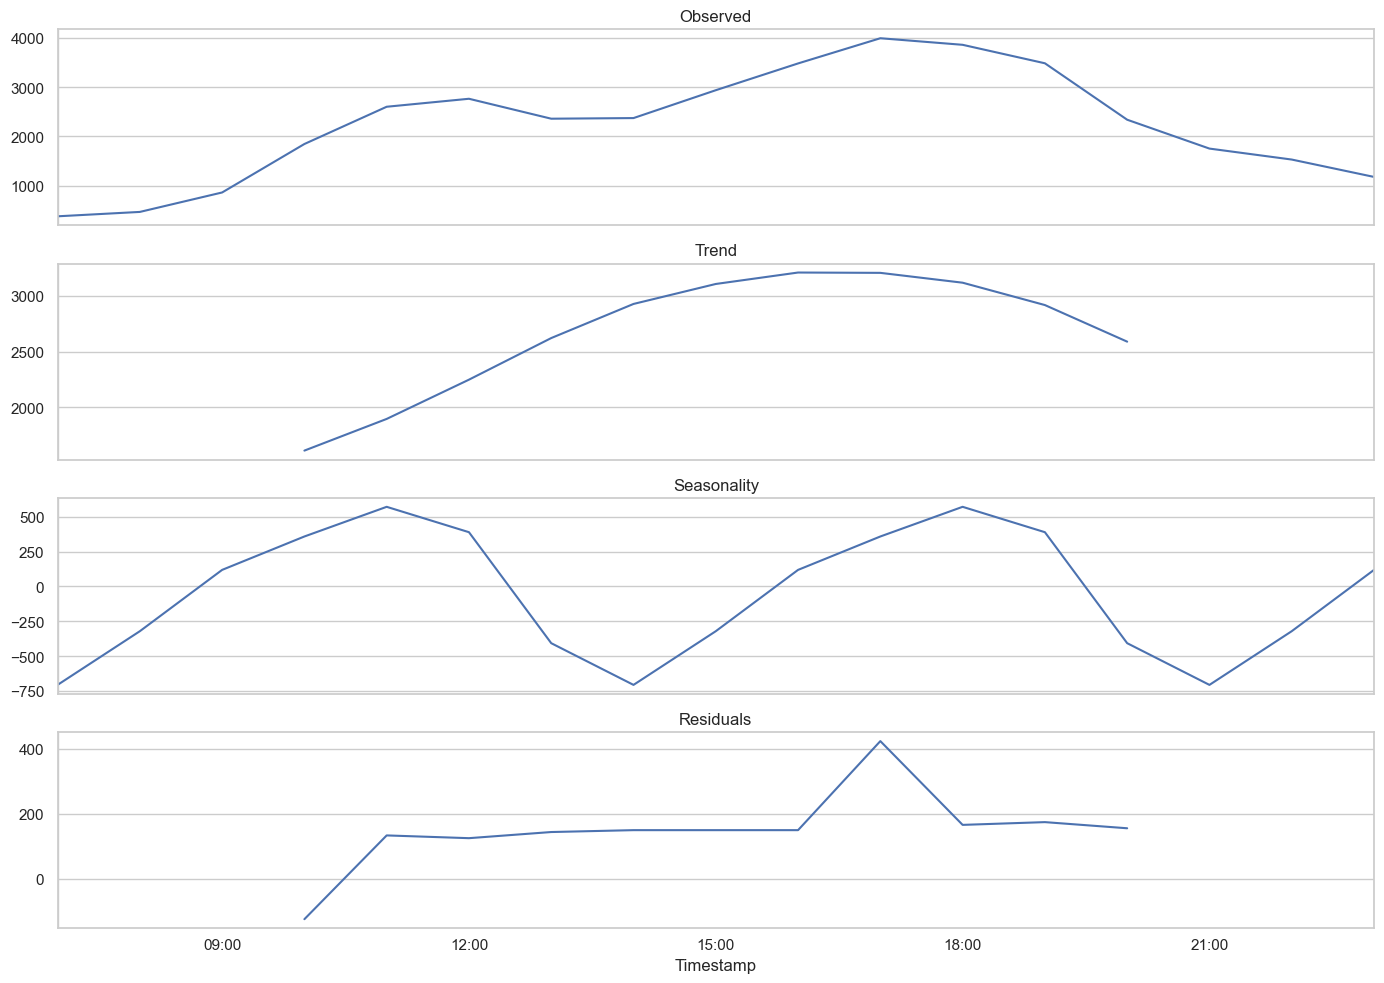

/var/folders/l7/xnyh1lh904xby1kp5mjh5fn40000gn/T/ipykernel_10269/608481662.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df[c].resample('H').mean()


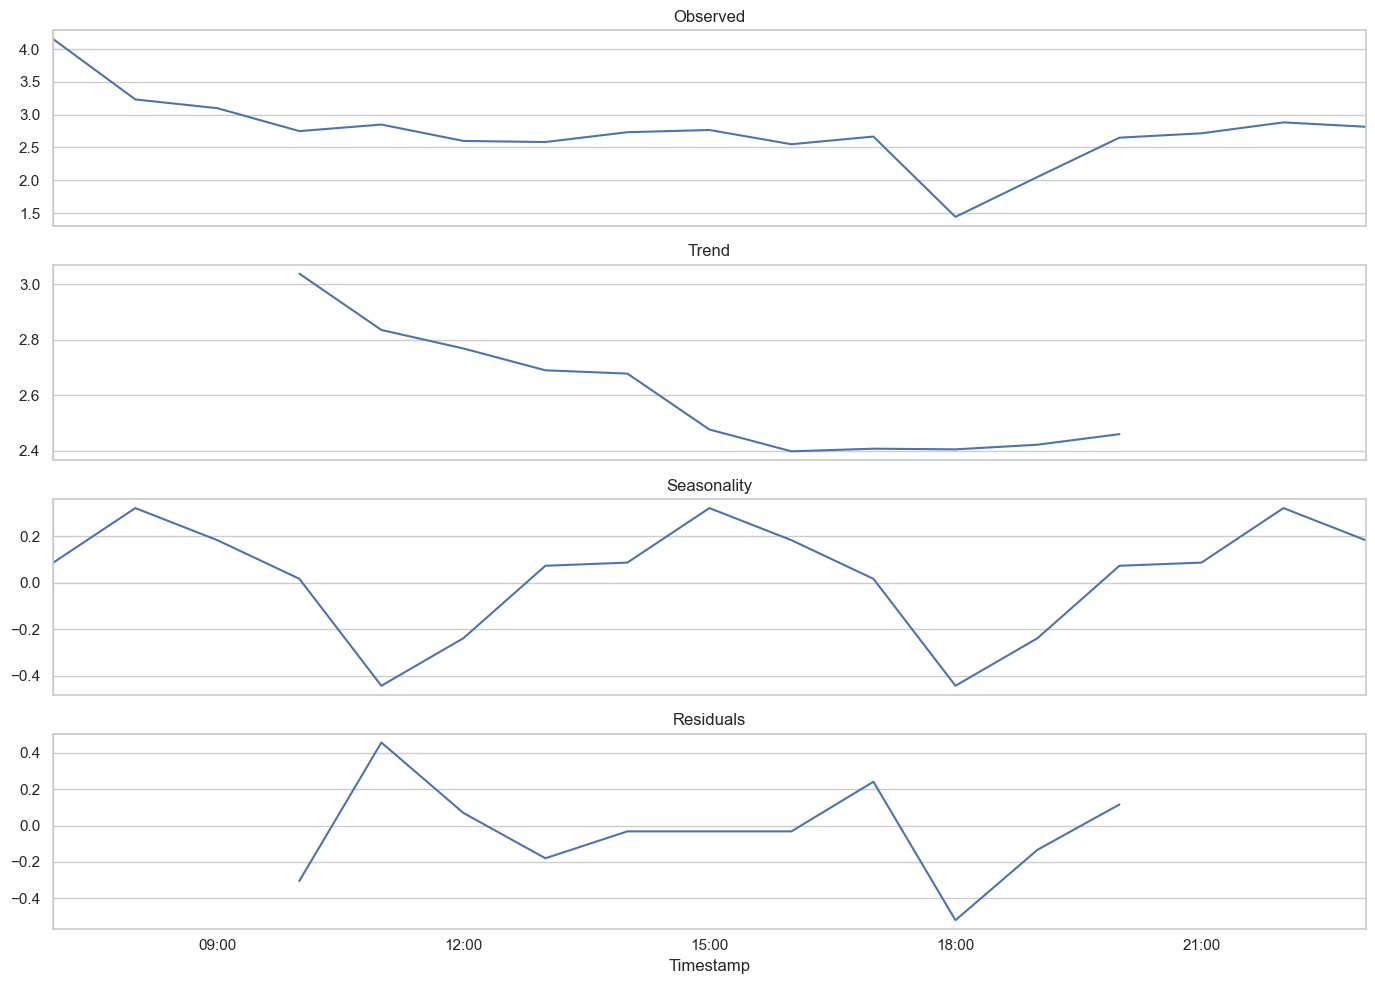

/var/folders/l7/xnyh1lh904xby1kp5mjh5fn40000gn/T/ipykernel_10269/608481662.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df[c].resample('H').mean()


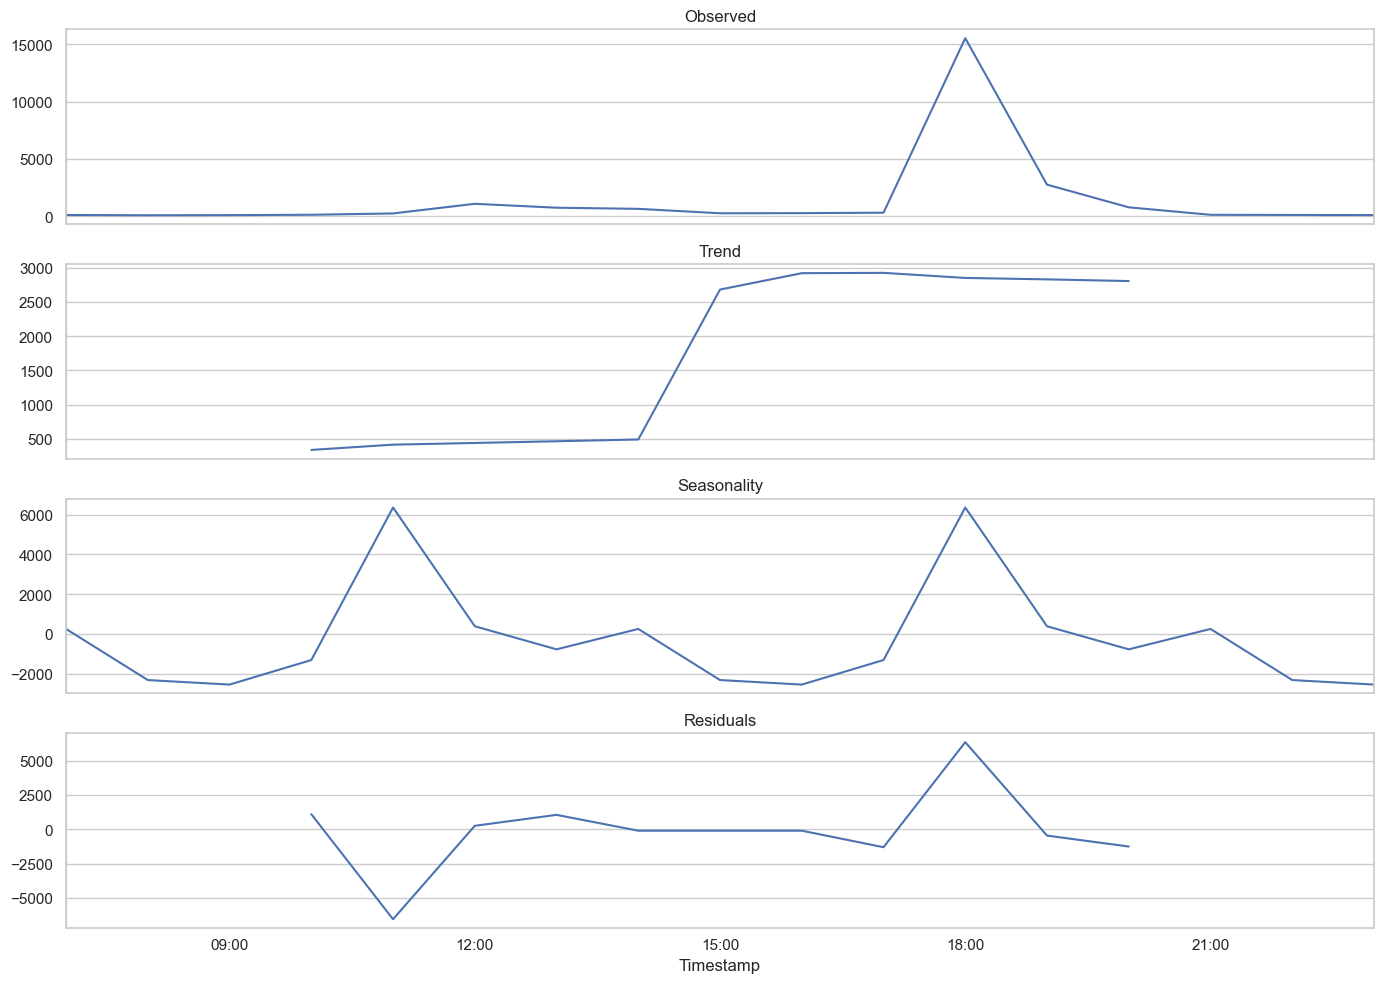

/var/folders/l7/xnyh1lh904xby1kp5mjh5fn40000gn/T/ipykernel_10269/608481662.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df[c].resample('H').mean()


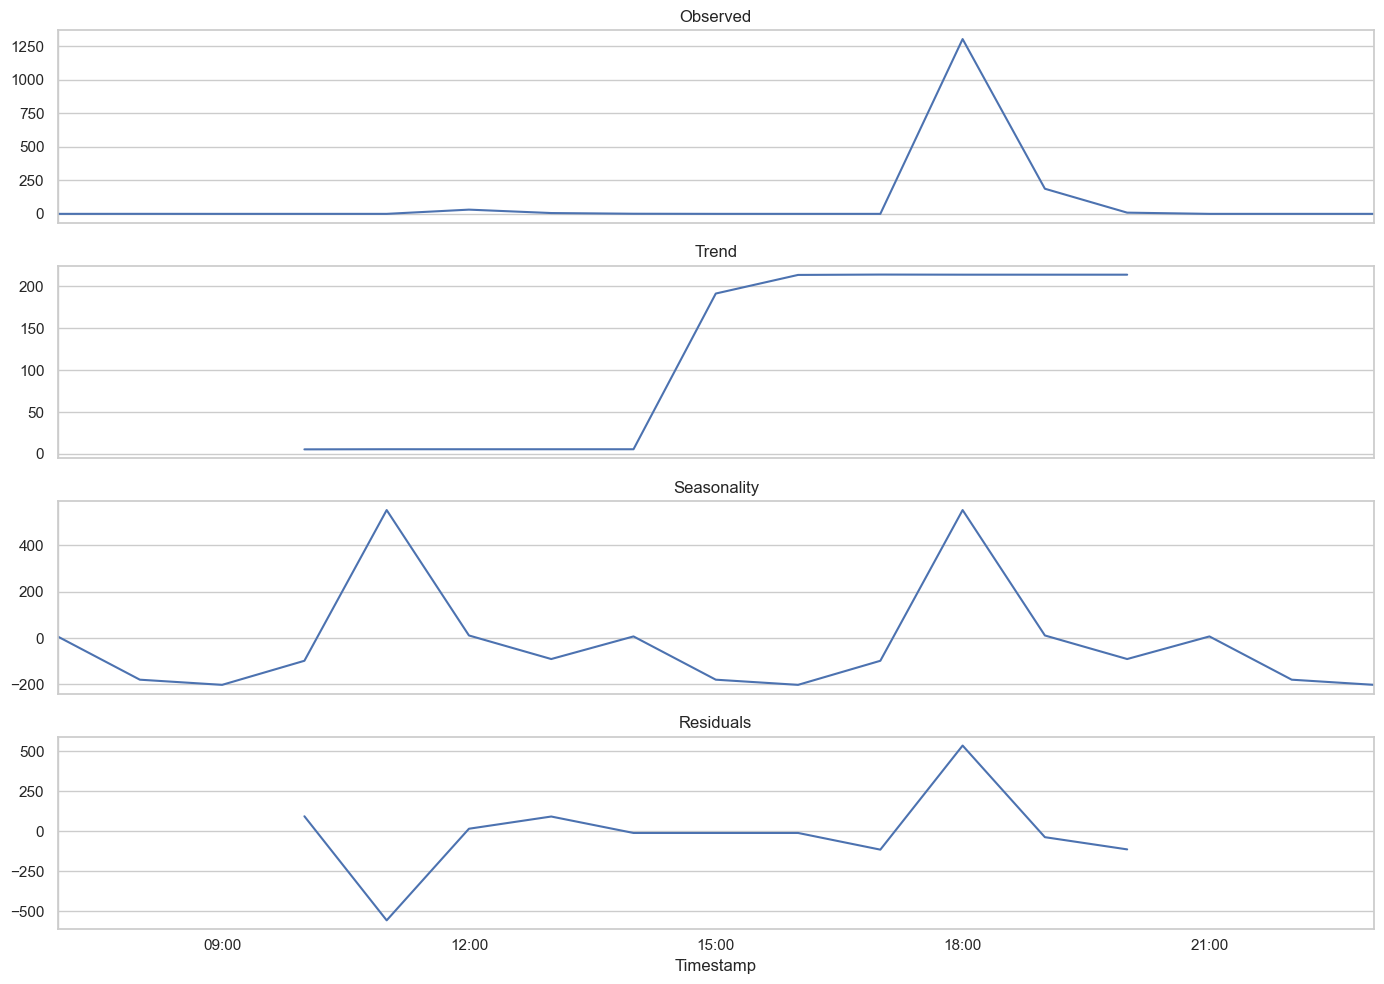

/var/folders/l7/xnyh1lh904xby1kp5mjh5fn40000gn/T/ipykernel_10269/608481662.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df[c].resample('H').mean()


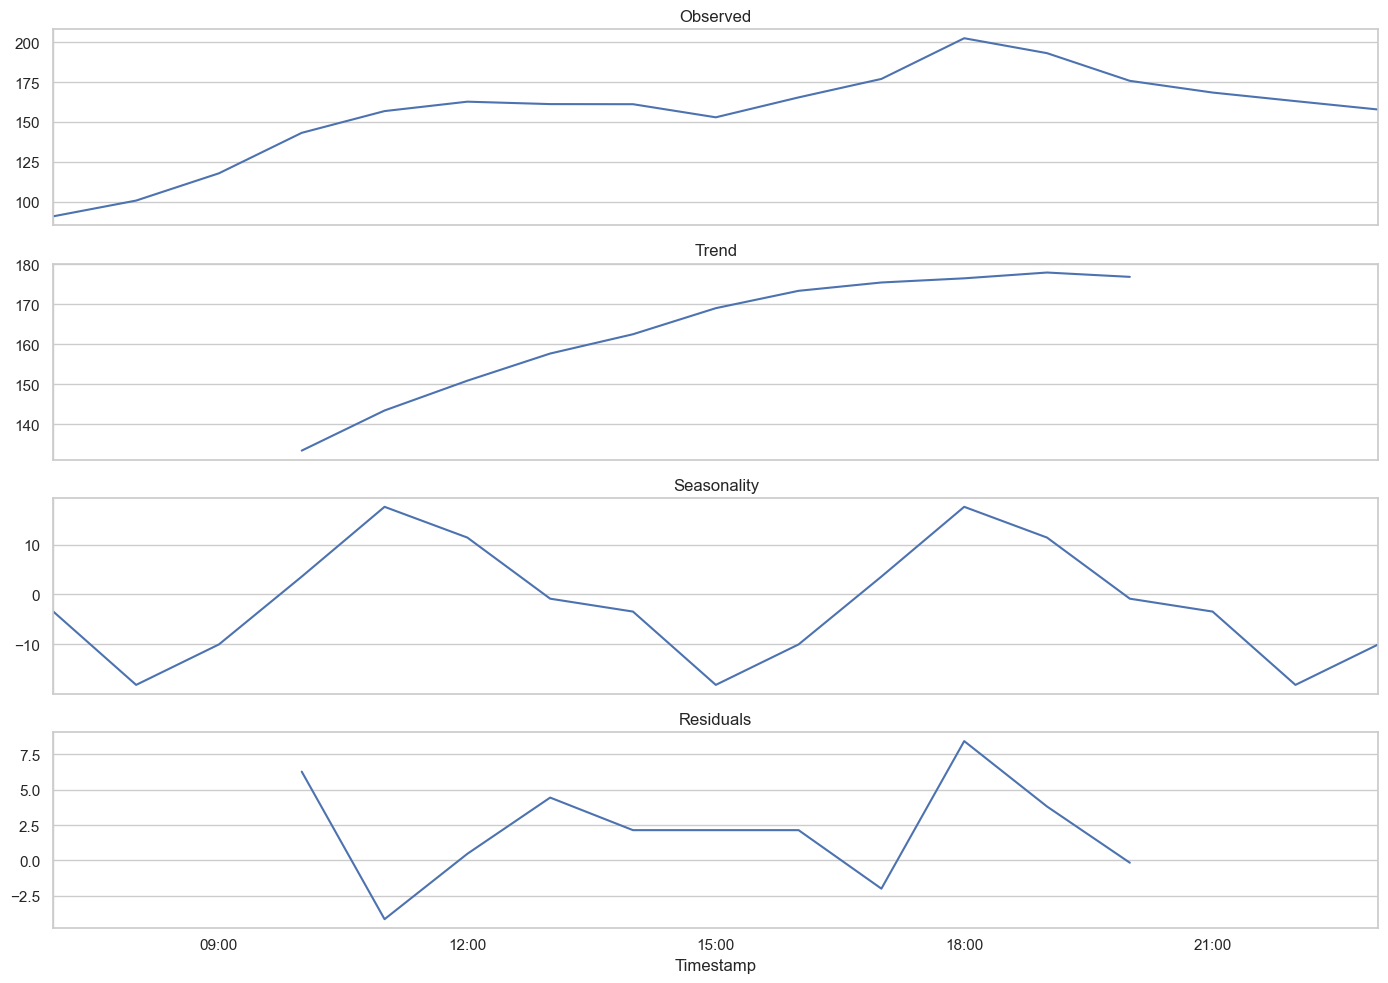

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose



for c in ['Number of Transactions', 'Time Min', 'Time Max', 'Retries', 'Wrong Transactions']:
    # Resample  
    
    df_resampled = df[c].resample('H').mean()  

    # remove NaN 
    df_resampled = df_resampled.dropna()

    # Decomposizione additiva 
    decomposition = seasonal_decompose(df_resampled, model='additive', period=7)  

    # Plot dei componenti
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    decomposition.observed.plot(ax=ax1, title='Observed')
    decomposition.trend.plot(ax=ax2, title='Trend')
    decomposition.seasonal.plot(ax=ax3, title='Seasonality')
    decomposition.resid.plot(ax=ax4, title='Residuals')
    plt.tight_layout()
    plt.show()

## Sliding Window, Scaling, and Train/Test Split

Created sliding windows (size = 24 hours) on main numerical features to prepare sequences for prediction.
 Target (`y`) is the `Number of Transactions` immediately after each window.
 Applied feature standardization with `StandardScaler`.
 Performed a time-aware train/test split (80/20) without shuffling to preserve temporal order.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#  1. SLIDING WINDOW on hourly basis 
window_size = 24  
features = ['Number of Transactions', 'Time Min', 'Time Max', 'Retries', 'Wrong Transactions']

X = []
y = []

for i in range(len(df) - window_size):
    X.append(df[features].iloc[i:i + window_size].values)
    y.append(df['Number of Transactions'].iloc[i + window_size])  # target = next value

X = np.array(X)
y = np.array(y)

#  2. FEATURE STANDARDIZATION
scaler = StandardScaler()
X_shape = X.shape
X = X.reshape(-1, X.shape[-1]) 
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X_shape)  



#  3. TRAIN / TEST SPLIT 
split_index = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Final output
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (795, 24, 5)
X_test shape: (199, 24, 5)
y_train shape: (795,)
y_test shape: (199,)


To start working with our deep learning models, we first installed TensorFlow, one of the most powerful and versatile machine learning libraries.


In [10]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


## LSTM and EarlyStopping

In this section, we train an LSTM model to predict the number of transactions, using normalization and early stopping to improve performance.

**Target normalization:** 
   Standardized `y_train` and `y_test` using `StandardScaler` to stabilize learning.

**LSTM model architecture:**
  Single LSTM layer followed by two Dense layers with ReLU activation, and a final output neuron.

 **EarlyStopping:** 
  Monitored validation loss to stop training early and avoid overfitting.

**Training:** 
   Trained the model on the standardized dataset, with validation on the test set.

**Predictions:** 
   Predicted on `X_test` and applied inverse scaling to restore the original scale of the outputs.

**Evaluation:** 
   Calculated MAE, RMSE, MAPE, and R² to assess prediction accuracy.

**Visualization:** 
   Plotted true vs predicted transaction volumes to visually compare model performance.

**Goal:** Accurately forecast the number of transactions over time using a normalized LSTM model optimized with early stopping.

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6208 - val_loss: 0.0513
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1003 - val_loss: 0.0639
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0789 - val_loss: 0.1149
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0635 - val_loss: 0.1272
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0660 - val_loss: 0.1287
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0599 - val_loss: 0.1123
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE:  198.05
RMSE: 263.06
MAPE: 12.87%
R²:   0.2418


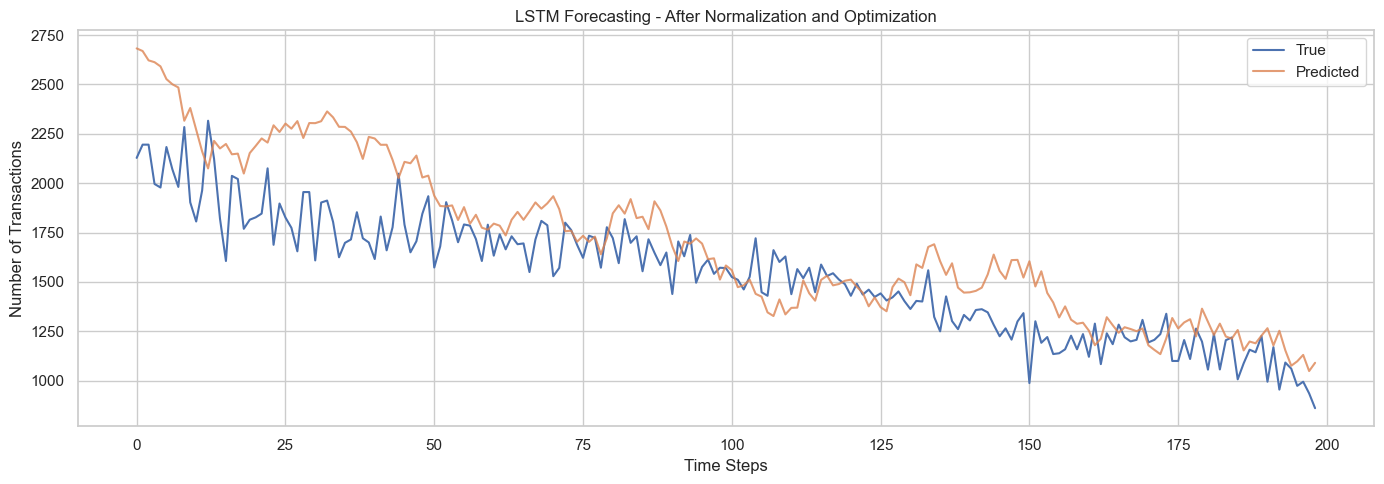

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

#  1. Target normalization 
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

#  2. LSTM model architecture 
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

#  3. EarlyStopping  prevent overfitting 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#  4. Training 
history1 = model.fit(
    X_train, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

#  5. Predictions and inverse scaling 
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)


#  6. Evaluation metrics 
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

#  7. Plot results 
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title("LSTM Forecasting - After Normalization and Optimization")
plt.xlabel("Time Steps")
plt.ylabel("Number of Transactions")
plt.legend()
plt.tight_layout()
plt.show()


## LSTM + Autoencoder 

In this section, we use a sequence autoencoder to generate synthetic time series data and retrain our LSTM model.

**Dataset preparation:** 
   Copied `X_train` and appended `y_train_scaled` to the last timestep as an additional feature.

**Sequence autoencoder architecture:**
  - Encoder: LSTM layer to compress sequences.
  - Bottleneck: Compressed representation repeated for decoding.
  - Decoder: LSTM + Dense layers to reconstruct the input sequence.

**Training:** 
   Trained the autoencoder on `Xy_train` for 50 epochs with 10% validation split.

**Synthetic data generation:** 
  - Predicted synthetic sequences from the autoencoder.
  - Separated synthetic features and targets, and inverse-transformed the target variable.

**Data augmentation:** 
   Combined real and synthetic data to create an enlarged training set.

**Retraining:** 
   Retrained an LSTM model on the augmented dataset to improve generalization.

**Evaluation:** 
  - Evaluated performance using MAE, RMSE, MAPE, and R².
  - Plotted true vs predicted transaction volumes to visualize the forecasting performance.

**Goal:** Improve forecasting accuracy by enriching the training set with synthetic sequences generated by the autoencoder.

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.0274 - val_loss: 0.6385
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5900 - val_loss: 0.6220
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6257 - val_loss: 0.6145
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6075 - val_loss: 0.5901
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4451 - val_loss: 0.5783
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4916 - val_loss: 0.5760
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4402 - val_loss: 0.5880
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4519 - val_loss: 0.5702
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4045 - val_loss: 0.5630
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3879 - val_loss: 0.5886
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4527 - val_loss: 0.5734
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3257 - val_loss: 0.3668
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0888 - val_loss: 0.4016
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0833 - val_loss: 0.4131
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0878 - val_loss: 0.3795
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0734 - val_loss: 0.3482
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0731 - val_loss: 0.3000
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0758 - val_loss: 0.2967
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0666 - val_loss: 0.2356
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0669 - val_loss: 0.2796
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0571 - val_loss: 0.2634
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0544 - val_loss: 0.2479
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0427 - val_

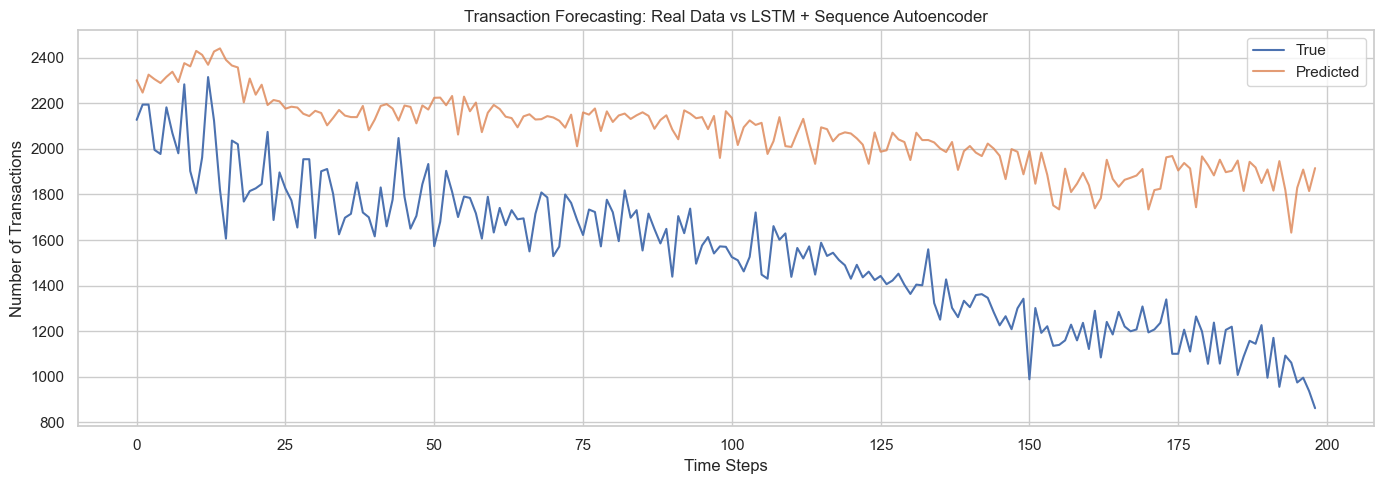

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed
import numpy as np

#   1: Concatenate X_train and y_train_scaled 


Xy_train = np.copy(X_train)
Xy_train[:, -1, -1] = y_train_scaled.flatten()  

#   2:  Sequence Autoencoder 
timesteps = Xy_train.shape[1]
features = Xy_train.shape[2]

input_seq = Input(shape=(timesteps, features))
encoded = LSTM(64, return_sequences=False)(input_seq)
bottleneck = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, return_sequences=True)(bottleneck)
decoded = TimeDistributed(Dense(features))(decoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

#   3: Train Autoencoder 
autoencoder.fit(Xy_train, Xy_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

#   4: Generate synthetic sequences 
synthetic_Xy = autoencoder.predict(Xy_train)

# Split synthetic_Xy back into X and y
synthetic_X = synthetic_Xy
synthetic_y_scaled = synthetic_Xy[:, -1, -1].reshape(-1, 1)

# Inverse scale y
synthetic_y = target_scaler.inverse_transform(synthetic_y_scaled)

# Remove last feature (target) from X
synthetic_X = np.copy(synthetic_X)
synthetic_X[:, -1, -1] = 0  

#   5: Combine real + synthetic data 
X_augmented = np.concatenate([X_train, synthetic_X])
y_augmented_scaled = np.concatenate([y_train_scaled, synthetic_y_scaled])

#   6: Retrain the LSTM 
model = Sequential([
    LSTM(64, input_shape=(X_augmented.shape[1], X_augmented.shape[2])),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history2 = model.fit(
    X_augmented, y_augmented_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

#  7: Evaluate  
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

plt.figure(figsize=(14, 5))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title("Transaction Forecasting: Real Data vs LSTM + Sequence Autoencoder")
plt.xlabel("Time Steps")
plt.ylabel("Number of Transactions")
plt.legend()
plt.tight_layout()
plt.show()

LSTM VS LSTM  autoencoder 
From this plot, we can observe that the LSTM model achieves a more effective loss function (tending toward zero) compared to the LSTM combined with an autoencoder. This indicates that, in this case (over 50 epochs), the standalone LSTM model performs better and shows superior training quality.

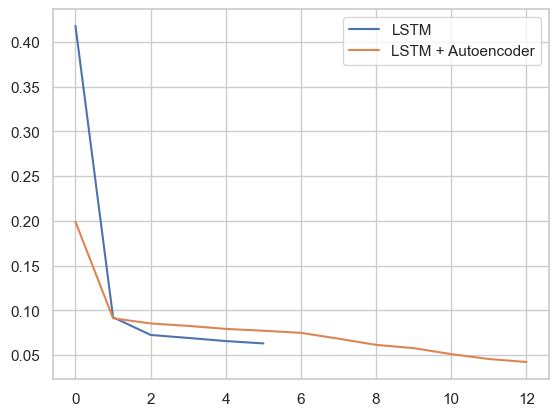

In [13]:
plt.plot(history1.history['loss'], label='LSTM')
plt.plot(history2.history['loss'], label='LSTM + Autoencoder')

plt.legend()

## LSTM+ GAN for Synthetic Time Series Generation  

In this section, we use a GAN to generate synthetic time series sequences and retrain the LSTM model on an augmented dataset.

 **Dataset preparation:**
  - Combined `X_train` with `y_train_scaled` by embedding the target into the last feature of each sequence.

 **GAN architecture:**
  - **Generator:** Dense + LSTM layers to create realistic sequences.
  - **Discriminator:** LSTM + Dense layers to classify sequences as real or fake.

 **Training process:**
  - Trained the discriminator to distinguish real and fake sequences.
  - Trained the generator to create sequences that fool the discriminator.
  - Monitored the training progress every 500 epochs.

 **Synthetic data generation:**
  - Generated 2000 synthetic sequences after training.
  - Separated synthetic features and target values, and inverse-transformed the target.

 **Data augmentation:**
  - Merged real and synthetic data to create a larger and more diverse training set.

 **Retraining the LSTM:**
  - Retrained the LSTM model using the augmented dataset.
  - Used EarlyStopping to prevent overfitting.

 **Evaluation:**
  - Assessed the model performance with MAE, RMSE, MAPE, and R² metrics.
  - Plotted the true vs predicted number of transactions for visual comparison.

**Goal:** Improve the LSTM model's forecasting accuracy by enriching the training data with synthetic sequences generated by a GAN.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6688, acc.: 73.44%] [G loss: 0.6754]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 27.4044 - val_loss: 0.0751
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0312 - val_loss: 0.0628
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0263 - val_loss: 0.0661
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0255 - val_loss: 0.0919
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0242 - val_loss: 0.0788
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0252 - val_loss: 0.0621
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0226 - val_loss: 0.0719
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0214 - val_loss: 0.0689
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0232 - val_loss: 0.0620
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0217 - val_loss: 0.0630
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0170 - val_loss: 0.0557
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0220 - val_

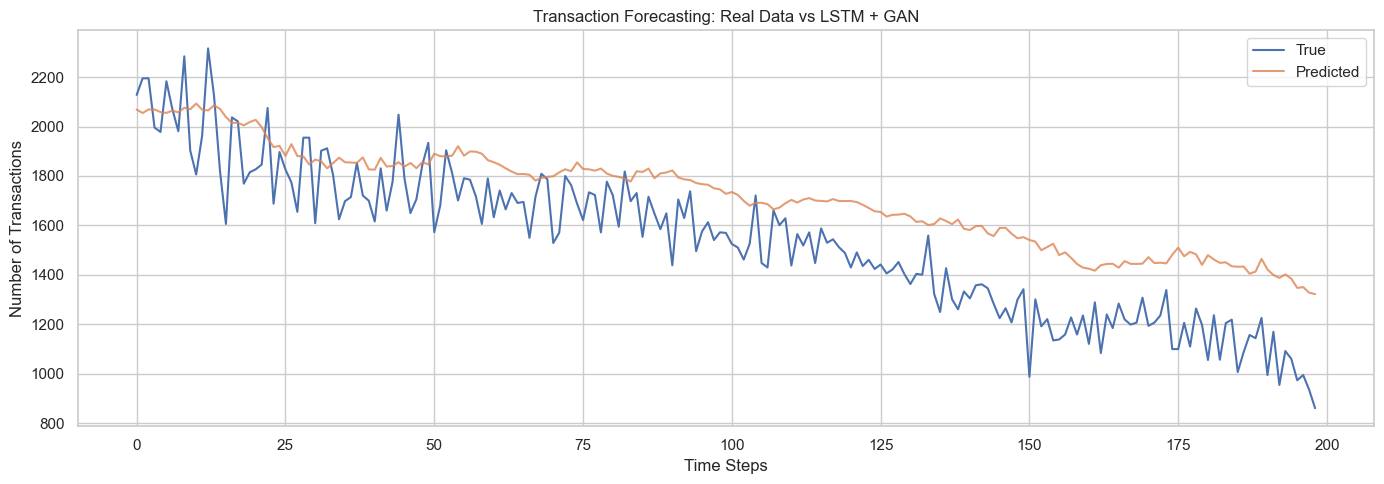

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Reshape, Flatten, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
import numpy as np

#  1. Prepara dataset (X + y_scaled nel punto finale)
Xy_train = np.copy(X_train)
Xy_train[:, -1, -1] = y_train_scaled.flatten()  

timesteps = Xy_train.shape[1]
features = Xy_train.shape[2]
latent_dim = 100

# --- 2. Crea il generatore ---
def build_generator():
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=latent_dim))
    model.add(RepeatVector(timesteps))
    model.add(LSTM(128, return_sequences=True))
    model.add(TimeDistributed(Dense(features)))
    return model

# --- 3. Crea il discriminatore ---
def build_discriminator():
    model = Sequential()
    model.add(LSTM(64, input_shape=(timesteps, features), return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# --- 4. Costruisci GAN ---
optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()

z = Input(shape=(latent_dim,))
generated_seq = generator(z)
discriminator.trainable = False
validity = discriminator(generated_seq)

gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

epochs = 1500 # da cambiare 
batch_size = 32
half_batch = batch_size // 2
history3 = []
for epoch in range(epochs):

    # Allenamento discriminatore 
    idx = np.random.randint(0, Xy_train.shape[0], half_batch)
    real_seqs = Xy_train[idx]

    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    gen_seqs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_seqs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_seqs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Allenamento generatore
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    # Ogni 500 epoche, stampa lo stato 
    if epoch % 500 == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

n_gen = 2000
noise = np.random.normal(0, 1, (n_gen, latent_dim))
synthetic_Xy = generator.predict(noise)

# separa y e X
synthetic_y_scaled = synthetic_Xy[:, -1, -1].reshape(-1, 1)
synthetic_y = target_scaler.inverse_transform(synthetic_y_scaled)

synthetic_X = np.copy(synthetic_Xy)
synthetic_X[:, -1, -1] = 0  # reset del target nella sequenza

X_augmented = np.concatenate([X_train, synthetic_X])
y_augmented_scaled = np.concatenate([y_train_scaled, synthetic_y_scaled])

# Nuovo LSTM
model = Sequential([
    LSTM(64, input_shape=(X_augmented.shape[1], X_augmented.shape[2])),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_augmented, y_augmented_scaled,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

#  Valutazione 
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")


plt.figure(figsize=(14, 5))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title("Transaction Forecasting: Real Data vs LSTM + GAN")
plt.xlabel("Time Steps")
plt.ylabel("Number of Transactions")
plt.legend()
plt.tight_layout()
plt.show()


After training the model, we generated predictions on the test set using model.predict(X_test). However, these predictions were still in a scaled (normalized) form, just like the data used during training. To make the results understandable and comparable to the real values, we applied an inverse transformation using the same scaler we had previously used on the target variable. This step converted the predictions back to their original scale, giving us values that made sense in the real-world context of our data.

In [15]:
# Regenerate predictions 
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


## Anomaly Detection on Forecasted Transactions

In this section, we detect anomalies in the forecasted transaction values using different techniques.

 **Error-based anomaly detection:** 
  - Calculated the absolute error between true and predicted values.
  - Defined a static threshold (mean error + 2 standard deviations) to flag anomalies.

 **Isolation Forest:**
  - Applied a tree-based unsupervised anomaly detection model.
  - Flagged observations classified as outliers by the Isolation Forest.

 **One-Class SVM:**
   Used a boundary-based unsupervised method (One-Class SVM with RBF kernel) to detect anomalies.

 **Comparative visualization:**
   Plotted true values and anomalies detected by each method for direct comparison.

 **Summary statistics:**
   Reported the number of anomalies detected by each technique.

**Goal:** Compare multiple anomaly detection strategies to identify unusual patterns in the number of transactions after LSTM forecasting.

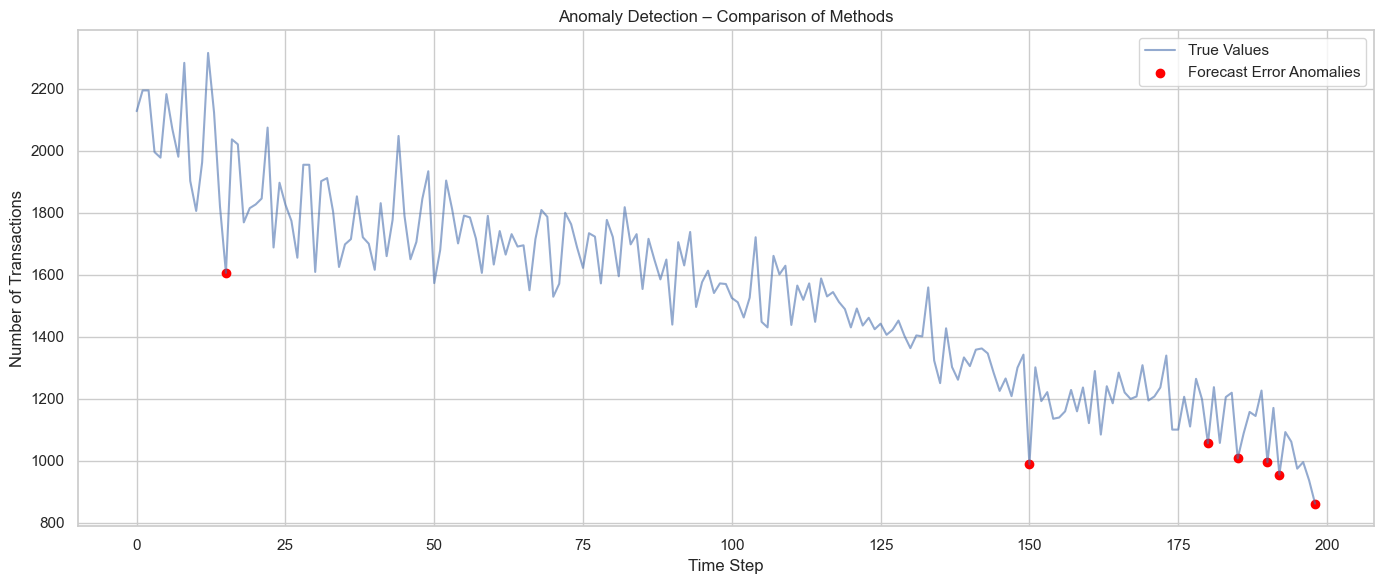

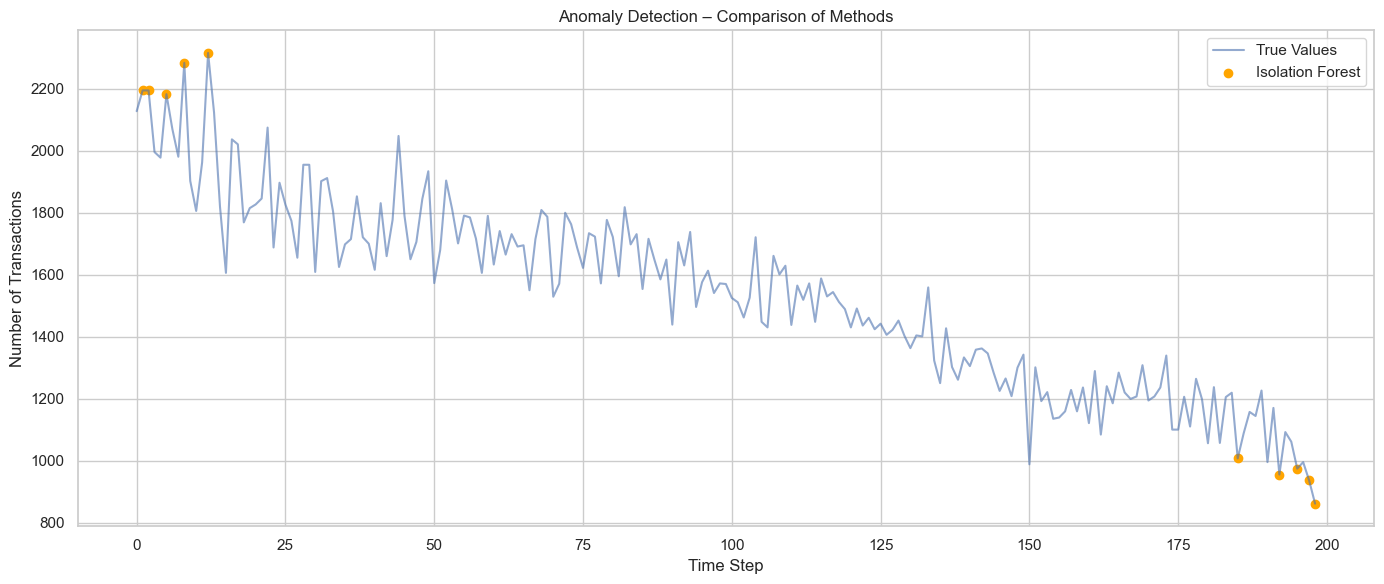

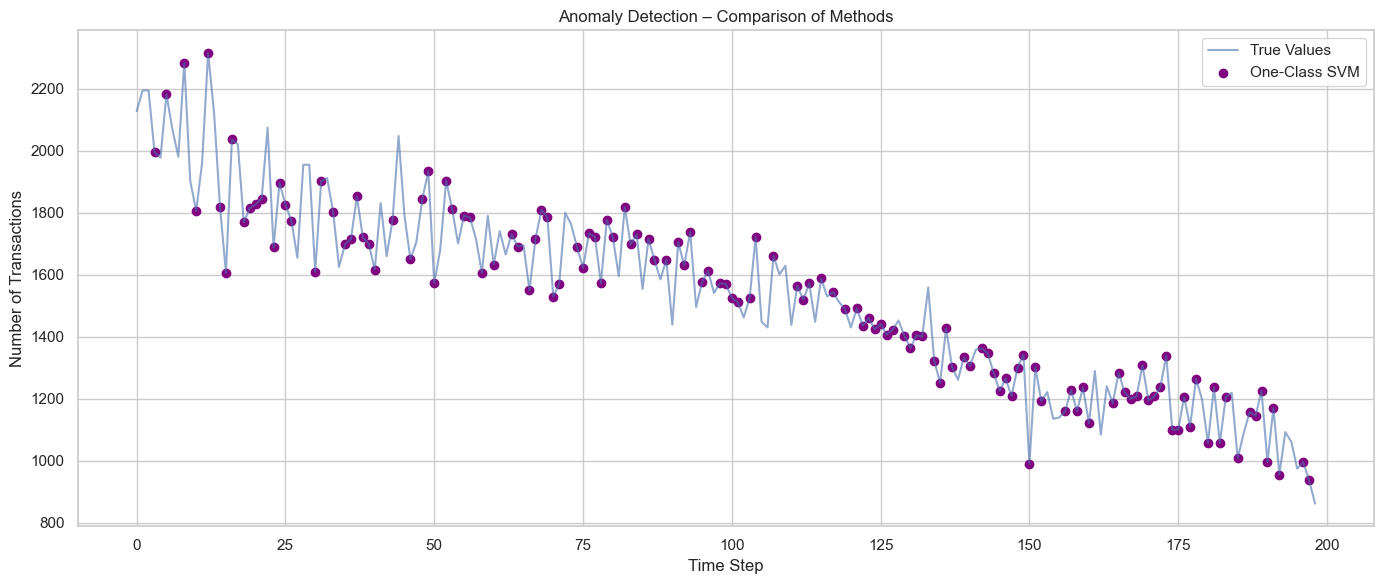

Static error threshold: 415.83
Anomalies (Forecast Error): 7 / 199
Anomalies (Isolation Forest): 10 / 199
Anomalies (One-Class SVM): 136 / 199


In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import numpy as np

# 1. Absolute error from LSTM predictions
errors = np.abs(y_test - y_pred.flatten())

# 2. Static threshold (mean + 2 standard deviations)
threshold = errors.mean() + 2 * errors.std()
anomalies_forecast = errors > threshold

# 3. Isolation Forest 
iso = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso.fit_predict(y_test.reshape(-1, 1))
anomalies_iso = iso_labels == -1

# 4. One-Class SVM 
svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
svm_labels = svm.fit_predict(y_test.reshape(-1, 1))
anomalies_svm = svm_labels == -1

# 5. Comparative visualization for  detected anomalies
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='True Values', alpha=0.6)
plt.scatter(np.where(anomalies_forecast)[0], y_test[anomalies_forecast], color='red', label='Forecast Error Anomalies')
plt.title("Anomaly Detection – Comparison of Methods")
plt.xlabel("Time Step")
plt.ylabel("Number of Transactions")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='True Values', alpha=0.6)
plt.scatter(np.where(anomalies_iso)[0], y_test[anomalies_iso], color='orange', label='Isolation Forest')
plt.title("Anomaly Detection – Comparison of Methods")
plt.xlabel("Time Step")
plt.ylabel("Number of Transactions")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(y_test, label='True Values', alpha=0.6)
plt.scatter(np.where(anomalies_svm)[0], y_test[anomalies_svm], color='purple', label='One-Class SVM')
plt.title("Anomaly Detection – Comparison of Methods")
plt.xlabel("Time Step")
plt.ylabel("Number of Transactions")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Summary statistics
print(f"Static error threshold: {threshold:.2f}")
print(f"Anomalies (Forecast Error): {anomalies_forecast.sum()} / {len(y_test)}")
print(f"Anomalies (Isolation Forest): {anomalies_iso.sum()} / {len(y_test)}")
print(f"Anomalies (One-Class SVM): {anomalies_svm.sum()} / {len(y_test)}")


## LSTM Autoencoder for Anomaly Detection on Time Series Sequences

In this section, we use an LSTM-based autoencoder to detect anomalies in time series data based on reconstruction errors.

**Sequence preparation:** 
  Used `X_train` and `X_test` as input sequences representing fixed-size time windows of the dataset.

**Autoencoder architecture:**
  - Encoder: LSTM layer that compresses the input sequence into a latent vector.
  - Decoder: LSTM + Dense layers that reconstruct the original input from the latent representation.

**Training:** 
  Trained the model to minimize reconstruction error using Mean Squared Error (MSE) on the training data.

**Reconstruction error:** 
  Computed the average reconstruction error for each test sequence.

**Dynamic anomaly threshold:**
  Calculated a rolling mean and standard deviation of reconstruction errors.
  Defined a dynamic threshold: `rolling_mean + k * std` (with fallback to `mean + 2σ` at the edges).

**Anomaly detection:**
  Flagged sequences where reconstruction error exceeded the dynamic threshold.

**Visualization:**
  Plotted reconstruction error, dynamic threshold, and detected anomalies over time.

**Goal:** Identify anomalous time periods where the model failed to accurately reconstruct the input, which may indicate irregular behavior in the system.

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 24, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 24, 5)          │           325 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,269 (200.27 KB)

 Trainable params: 51,269 (200.27 KB)

 Non-trainable params: 0 (0.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


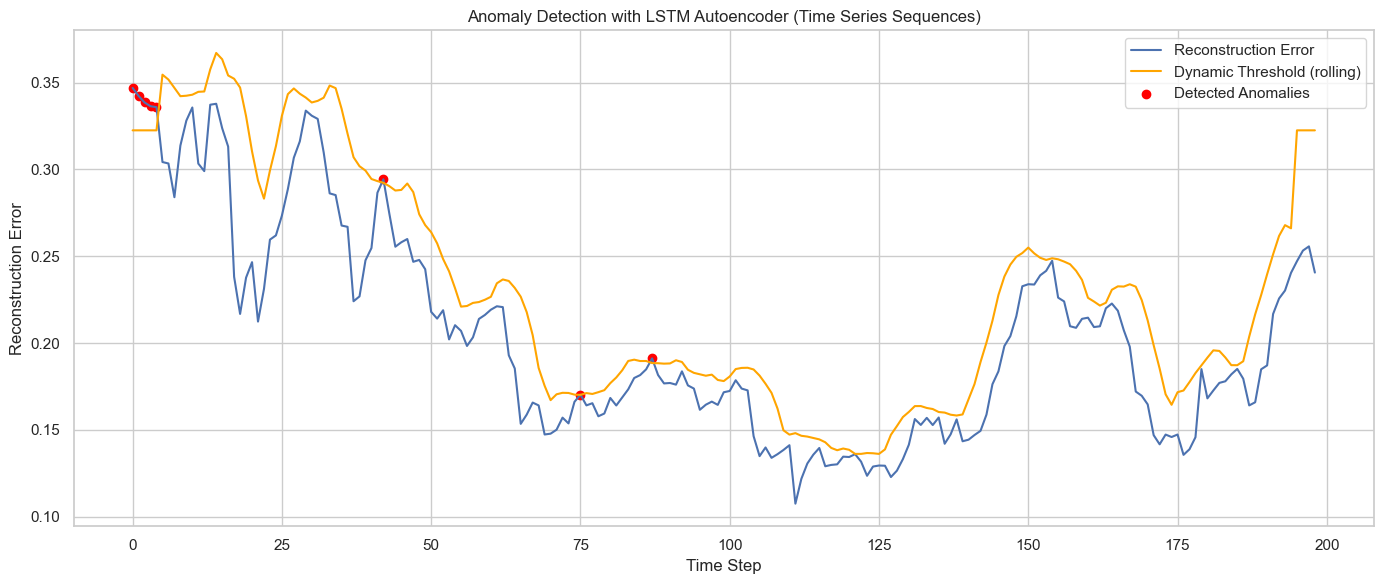

Detected anomalies: 8 / 199


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import StandardScaler

#  1. Prepare sequence data (X_train, X_test ) 

X_train_seq = X_train
X_test_seq = X_test

#  2. LSTM Autoencoder construction 
timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu')(input_layer)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

#  3. Training 
autoencoder.fit(X_train_seq, X_train_seq,
                epochs=50,
                batch_size=32,
                validation_split=0.1,
                verbose=0)

#  4. Reconstruction error computation 
X_pred = autoencoder.predict(X_test_seq)
reconstruction_errors = np.mean(np.mean(np.square(X_test_seq - X_pred), axis=2), axis=1)

#  5. Dynamic threshold: rolling mean + k*std 
rolling_mean = pd.Series(reconstruction_errors).rolling(window=10, center=True).mean()
rolling_std = pd.Series(reconstruction_errors).rolling(window=10, center=True).std()
k = 1.5
dynamic_threshold = rolling_mean + k * rolling_std

#  NaN at the edges using  fallback threshold (mean + 2σ)
fallback_threshold = reconstruction_errors.mean() + 2 * reconstruction_errors.std()
dynamic_threshold = dynamic_threshold.fillna(fallback_threshold)

# Anomalies where error > dynamic threshold
anomalies_autoenc = reconstruction_errors > dynamic_threshold

#  6. Final Visualization 
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.plot(dynamic_threshold, label='Dynamic Threshold (rolling)', color='orange')
plt.scatter(np.where(anomalies_autoenc)[0], reconstruction_errors[anomalies_autoenc],
            color='red', label='Detected Anomalies')
plt.title("Anomaly Detection with LSTM Autoencoder (Time Series Sequences)")
plt.xlabel("Time Step")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.tight_layout()
plt.show()

# Final report
print(f"Detected anomalies: {anomalies_autoenc.sum()} / {len(reconstruction_errors)}")


## LSTM Sparse Autoencoder for Anomaly Detection

In this section, we use a sparsity-regularized LSTM autoencoder to detect anomalies in time series sequences.

**Sequence preparation:**
   Used preprocessed sliding windows (`X_train`, `X_test`) as input sequences.

**Sparse autoencoder architecture:**
  Encoder: LSTM layer with L1 activity regularization to encourage sparsity in the latent representation.
  Decoder: LSTM + Dense layers to reconstruct the input sequence.
  Loss: Mean Squared Error (MSE), optimized with Adam.

**Training:**
   Trained the model for 50 epochs with a 10% validation split, silently (`verbose=0`).

**Reconstruction error:**
   Calculated average reconstruction error across time and features for each sequence in the test set.

**Dynamic thresholding:**
  Used a rolling window (mean + 1.5×std) to adapt the threshold over time.
  Fallback to static threshold (`mean + 2σ`) to handle NaNs at the edges.

**Anomaly detection:**
  Flagged sequences as anomalies if their reconstruction error exceeded the dynamic threshold.

**Visualization:**
   Plotted reconstruction error, dynamic threshold, and detected anomalies to analyze model behavior.

**Goal:** Detect subtle or sparse anomalies by leveraging a latent representation that penalizes overly complex (non-sparse) encodings.

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 24, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 24, 5)          │           325 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,269 (200.27 KB)

 Trainable params: 51,269 (200.27 KB)

 Non-trainable params: 0 (0.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


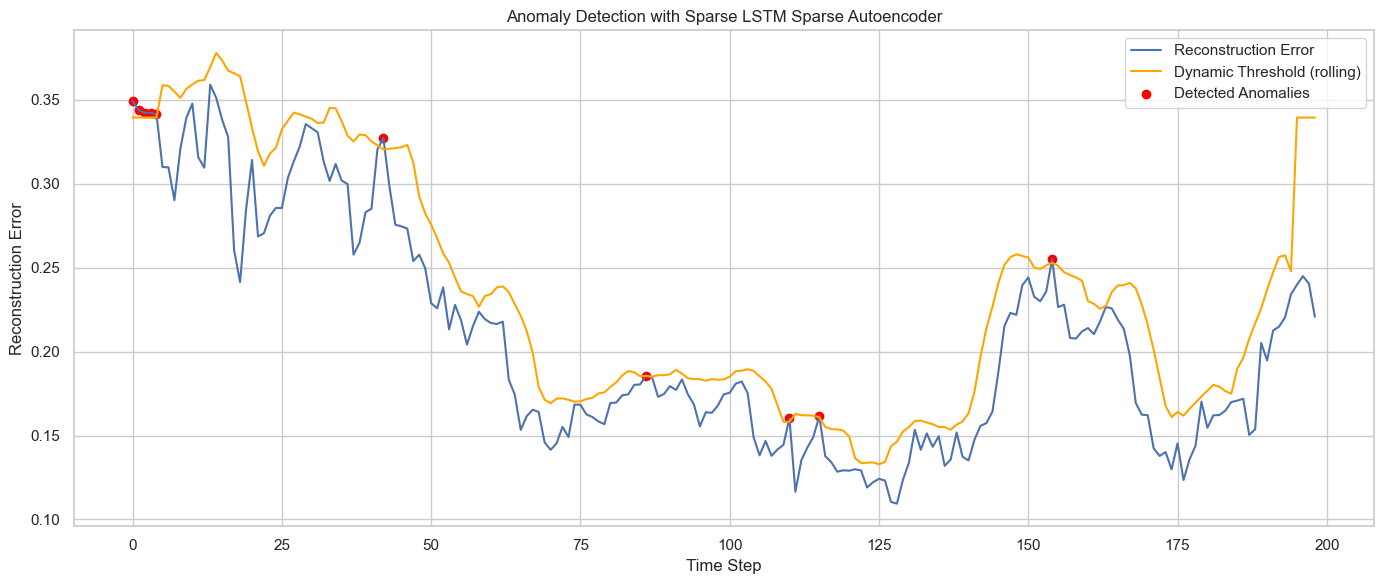

Detected anomalies: 10 / 199


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.regularizers import l1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  1. Sequence data 
X_train_seq = X_train
X_test_seq = X_test

#  2. Sparse LSTM Autoencoder 
timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

input_layer = Input(shape=(timesteps, n_features))

#  Adding L1 regularization for  encourage sparsity
encoded = LSTM(64, activation='relu', activity_regularizer=l1(1e-4))(input_layer)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

#  3. Training 
autoencoder.fit(X_train_seq, X_train_seq,
                epochs=50,
                batch_size=32,
                validation_split=0.1,
                verbose=0)

#  4. Reconstruction Error 
X_pred = autoencoder.predict(X_test_seq)
reconstruction_errors = np.mean(np.mean(np.square(X_test_seq - X_pred), axis=2), axis=1)

#  5. Dynamic Threshold 
rolling_mean = pd.Series(reconstruction_errors).rolling(window=10, center=True).mean()
rolling_std = pd.Series(reconstruction_errors).rolling(window=10, center=True).std()
k = 1.5
dynamic_threshold = rolling_mean + k * rolling_std
fallback_threshold = reconstruction_errors.mean() + 2 * reconstruction_errors.std()
dynamic_threshold = dynamic_threshold.fillna(fallback_threshold)

anomalies_autoenc = reconstruction_errors > dynamic_threshold

#  6. Visualization 
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.plot(dynamic_threshold, label='Dynamic Threshold (rolling)', color='orange')
plt.scatter(np.where(anomalies_autoenc)[0], reconstruction_errors[anomalies_autoenc],
            color='red', label='Detected Anomalies')
plt.title("Anomaly Detection with Sparse LSTM Sparse Autoencoder")
plt.xlabel("Time Step")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Detected anomalies: {anomalies_autoenc.sum()} / {len(reconstruction_errors)}")

## Multivariate Anomaly Detection via Outlier Persistence

In this section, we detect anomalies by analyzing persistent deviations across multiple features using a sliding window approach.

**Data preparation:**
   Selected key numerical features and standardized them using `StandardScaler`.

**Outlier identification:**
  Marked as outliers the values where the absolute standardized score exceeds 1 ( |z| > 1).

**Persistence detection:**
   Applied a sliding window (size = 10) to count how long each value stays in the outlier region.

**Anomaly scoring:**
   Summed persistence counts across all features to get a total anomaly score per time step.

**Thresholding:**
   Defined anomalies as time steps where the total score exceeds the 95th percentile.

**Visualization:**
   For each feature, plotted values over time and highlighted detected anomalies.

**Goal:** Detect time steps with sustained abnormal behavior across multiple features, rather than isolated outlier spikes.

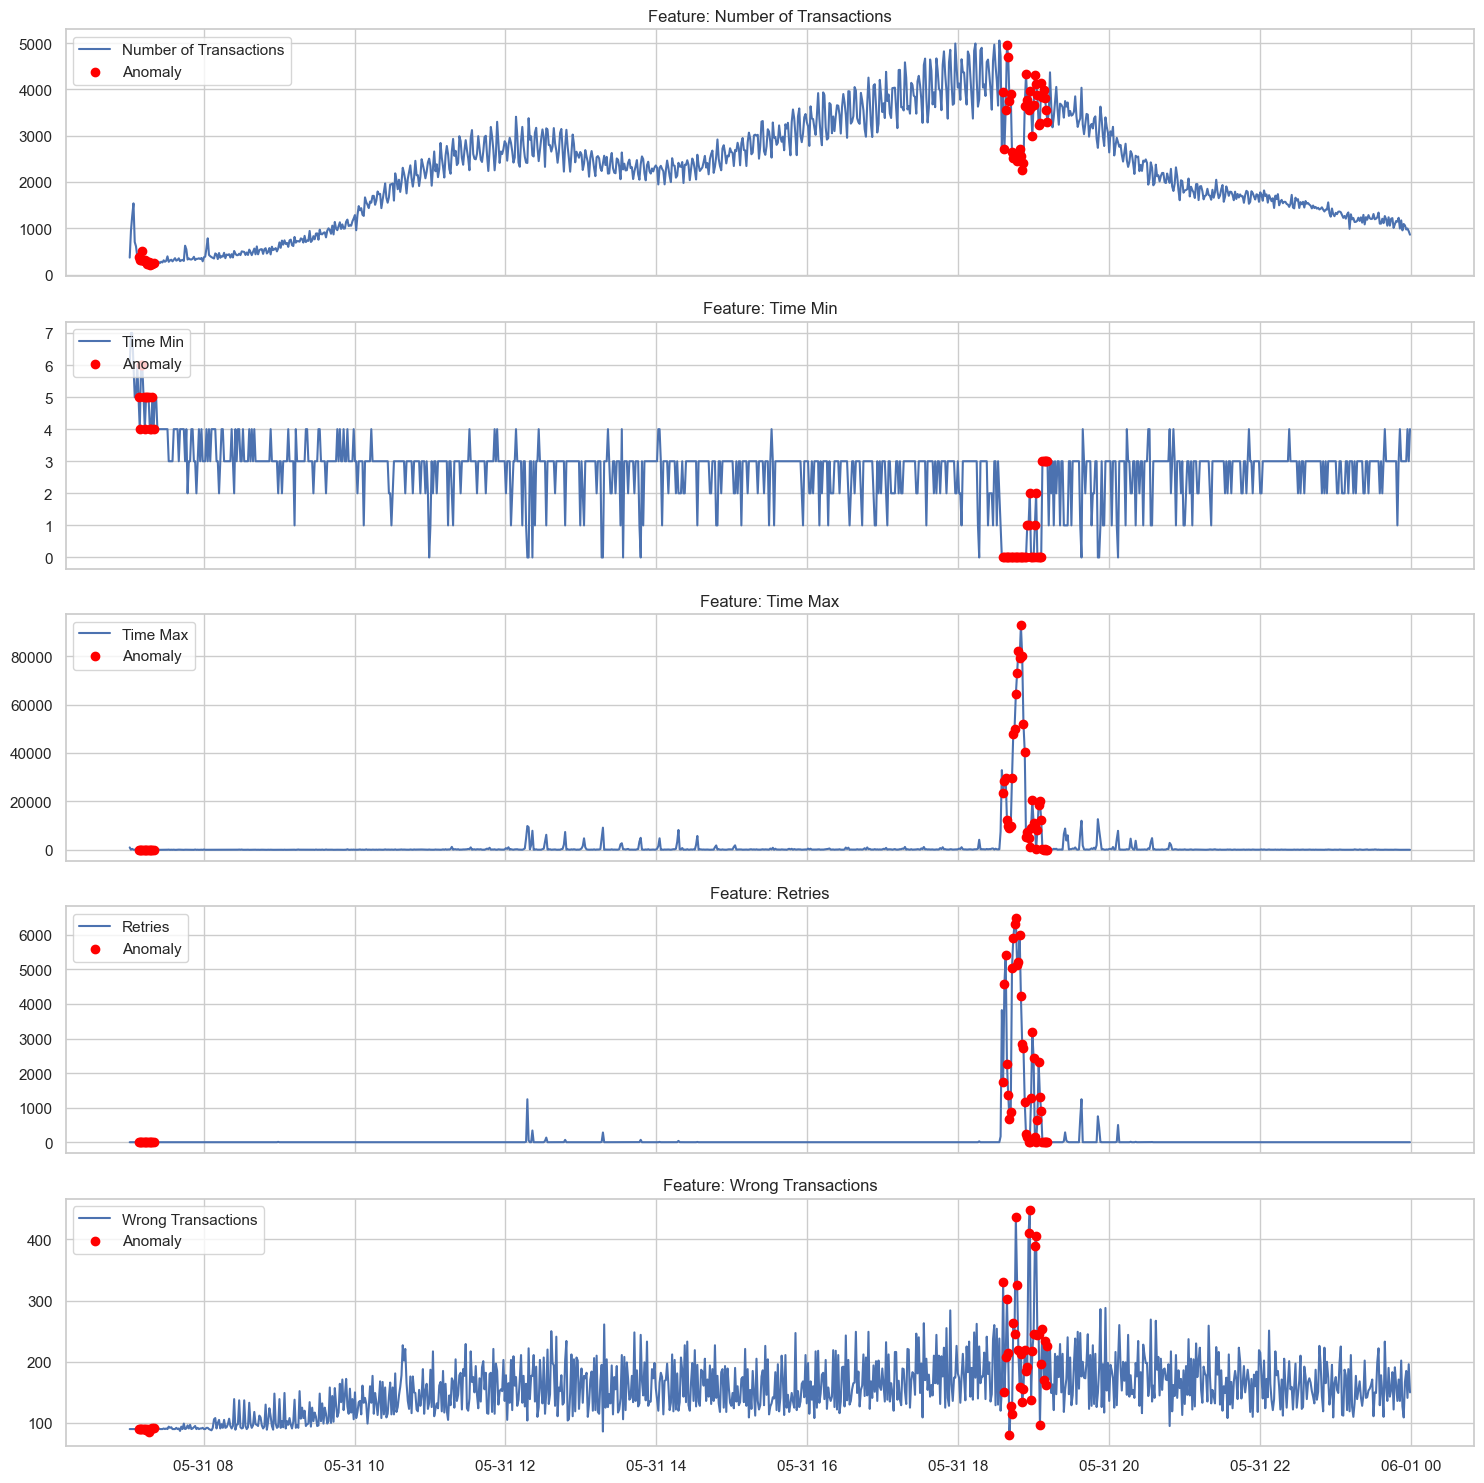

In [21]:
features = ['Number of Transactions', 'Time Min', 'Time Max', 'Retries', 'Wrong Transactions']
data = df[features].dropna().copy()
data
percentile_threshold = 95

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

# 2. Create boolean DataFrame of "outlier points" where |value| > 1
outliers = (data_scaled.abs()).astype(int)

# 3. Apply a sliding window and count persistence over the threshold
persistence = outliers.rolling(window=10, min_periods=1).sum()

# 4. Aggregate over features to get a score for each time step
anomaly_score = persistence.sum(axis=1)

# 5. Threshold based on percentile of the score
threshold = np.percentile(anomaly_score, percentile_threshold)
anomalies = anomaly_score > threshold

num_features = data.shape[1]
fig, axes = plt.subplots(num_features, 1, figsize=(15, 3 * num_features), sharex=True)
if num_features == 1:
    axes = [axes] 

for i, col in enumerate(data.columns):
    ax = axes[i]
    ax.plot(data.index, data[col], label=col)
    ax.scatter(data.index[anomalies], data[col][anomalies], color='red', label='Anomaly', zorder=5)
    ax.set_title(f"Feature: {col}")
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()

we converted the entire dataset to floating-point numbers,

In [22]:
data = data.astype(float)

## Anomaly Detection via Deviation from Rolling Statistics

In this section, we detect anomalies by identifying values that persistently deviate from their rolling mean across multiple features.

 **Rolling statistics:**
   Computed rolling mean and standard deviation with a 24-step window to capture local trends.

 **Outlier detection:**
   Flagged time points where values exceed 1 standard deviation from the rolling mean ( `|x - μ| > σ`).

 **Persistence analysis:**
   Used a sliding window to measure how long the deviation persists for each feature.

 **Anomaly scoring:**
   Summed persistence across all features to assign a total anomaly score to each time step.

 **Thresholding:**
  Detected anomalies as time steps with scores above the 95th percentile.

 **Visualization:**
  For each feature, plotted the original values, rolling mean ± std band, and highlighted anomalies.

**Goal:** Capture anomalies that show sustained deviation from normal behavior patterns over time, instead of isolated spikes.

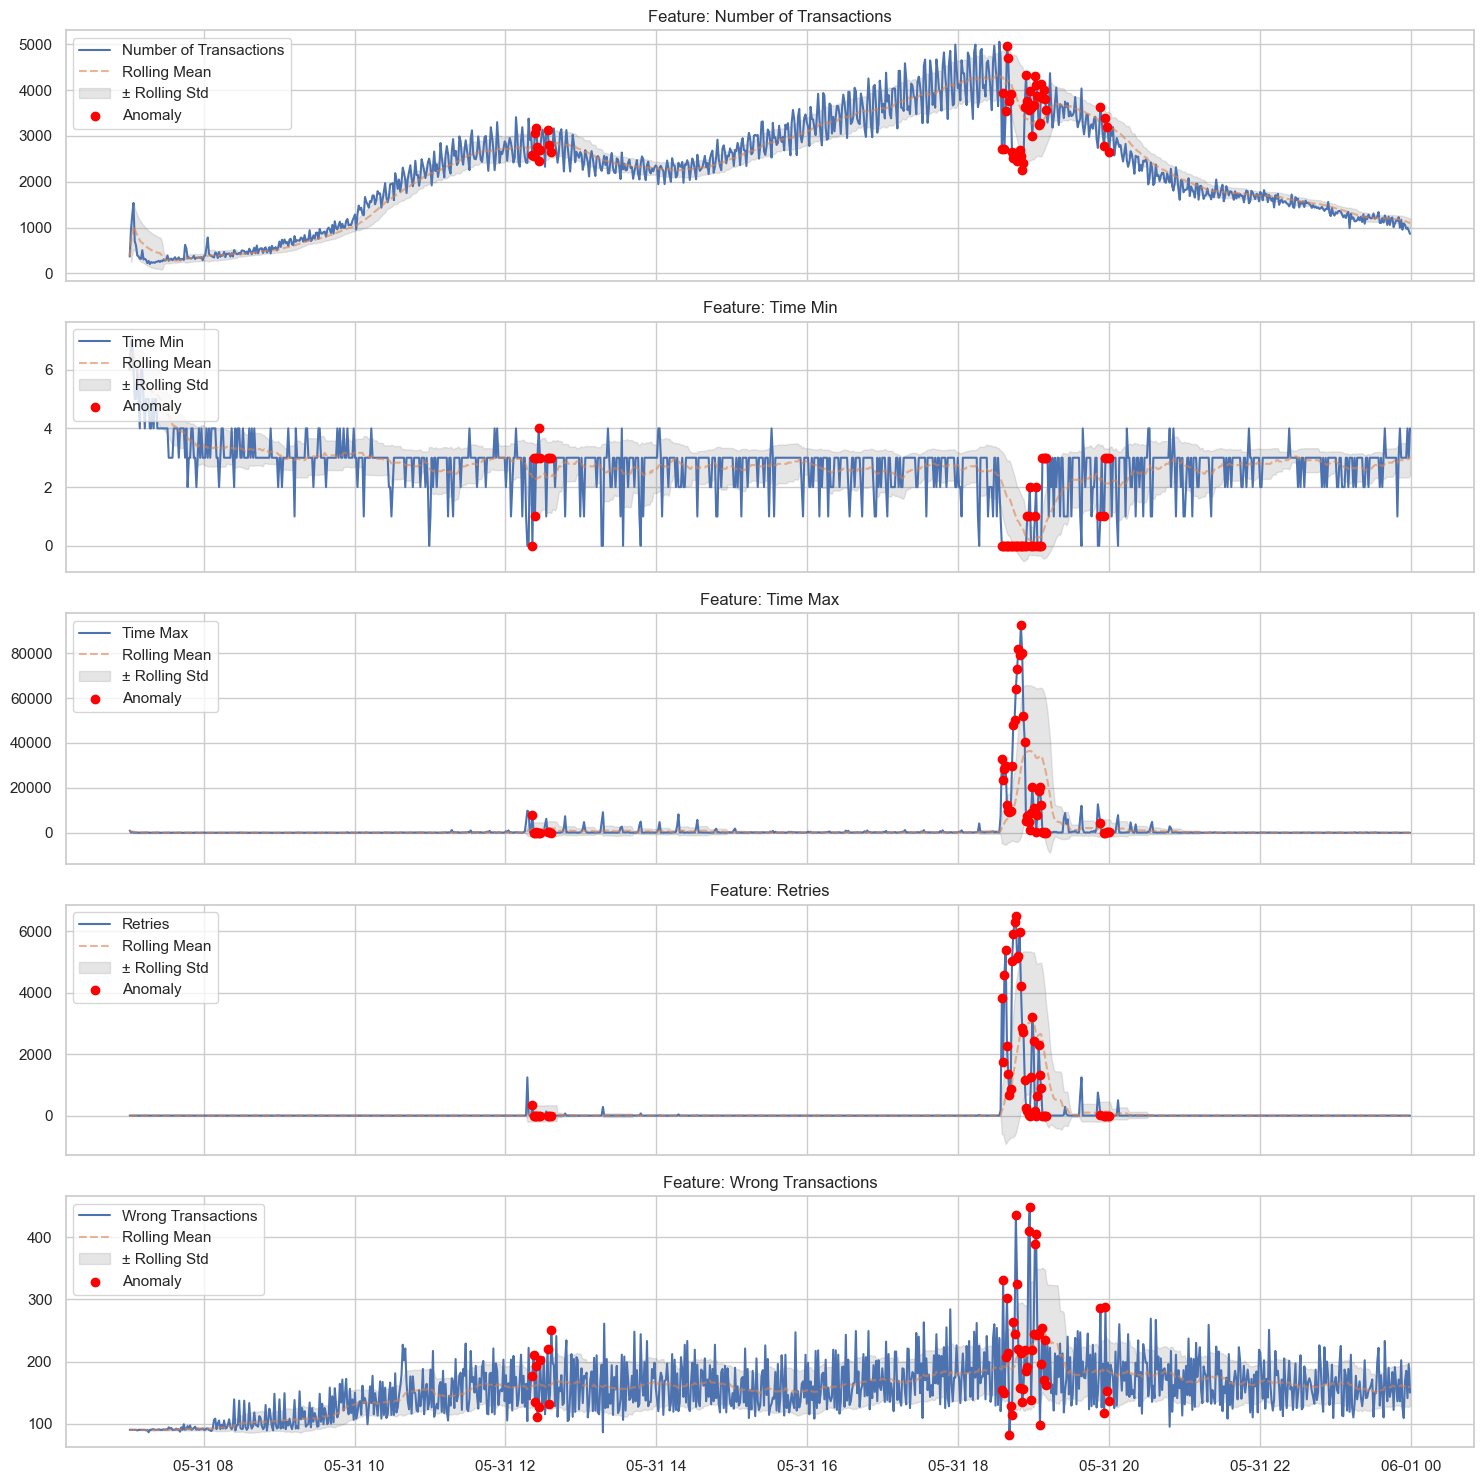

In [23]:
# Step 1: Compute rolling mean and std
rolling_window = 24
rolling_mean = data.rolling(window=rolling_window, min_periods=1).mean()
rolling_std = data.rolling(window=rolling_window, min_periods=1).std()

# Step 2: Flag values where |x - rolling_mean| > rolling_std
outliers = ((data - rolling_mean).abs() / rolling_std)

# Step 3: Count persistence in a sliding window
persistence = outliers.rolling(window=window_size, min_periods=1).sum()

# Step 4: Aggregate persistence across features into anomaly score
anomaly_score = persistence.sum(axis=1)

# Step 5: Threshold based on percentile
threshold = np.percentile(anomaly_score, percentile_threshold)
anomalies = anomaly_score > threshold

num_features = data.shape[1]
fig, axes = plt.subplots(num_features, 1, figsize=(15, 3 * num_features), sharex=True)
if num_features == 1:
    axes = [axes]

for i, col in enumerate(data.columns):
    ax = axes[i]
    ax.plot(data.index, data[col], label=col)
    ax.plot(rolling_mean.index, rolling_mean[col], linestyle='--', alpha=0.6, label='Rolling Mean')
    ax.fill_between(data.index,
                    rolling_mean[col] - rolling_std[col],
                    rolling_mean[col] + rolling_std[col],
                    color='gray', alpha=0.2, label='± Rolling Std')
    ax.scatter(data.index[anomalies], data[col][anomalies], color='red', label='Anomaly', zorder=5)
    ax.set_title(f"Feature: {col}")
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
git --version